# Ion Switching

This notebook analyses simulated patch-clamp electrophysiology data, with the goal of making a predictive model that can determine the number of open ion channels from the current signal. This is a competitive machine learning project hosted on Kaggle:

https://www.kaggle.com/c/liverpool-ion-switching/overview

The challenge is based on [this paper](https://www.nature.com/articles/s42003-019-0729-3) in which fake patch clamp data was used to train a deep learning model that was then successful at classifying real-world data (hand-labeled by electrophysiologists).

In [3]:
import pandas as pd
import numpy as np
import sklearn
import random
from random import randint
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

## Import and Describe Data

In [4]:
df_ts = pd.read_csv('open_channels.csv')
df_ts.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [5]:
df_ts.describe()

,time,signal,open_channels
count,5.000000e+06,5.000000e+06,5.000000e+06
mean,2.500001e+02,1.386246e+00,2.726043e+00
std,1.443376e+02,3.336219e+00,2.665051e+00
min,1.000000e-04,-5.796500e+00,0.000000e+00
25%,1.250001e+02,-1.594800e+00,1.000000e+00
50%,2.500000e+02,1.124000e+00,2.000000e+00
75%,3.750000e+02,3.690100e+00,4.000000e+00
max,5.000000e+02,1.324400e+01,1.000000e+01


The training data includes a timestamp in seconds (in increments of 100 μs), a voltage signal, and a label indicating the number of open ion channels. There are 5 million samples, and we know from the project description on Kaggle that these 5 million samples are actually from 10 sets of 500,000 samples corresponding to discrete 50 s recordings. The current signal ranges from about -5.8 to +13.2 pA. The number of open channels ranges from 0 to 10.

## Plot Sample Data

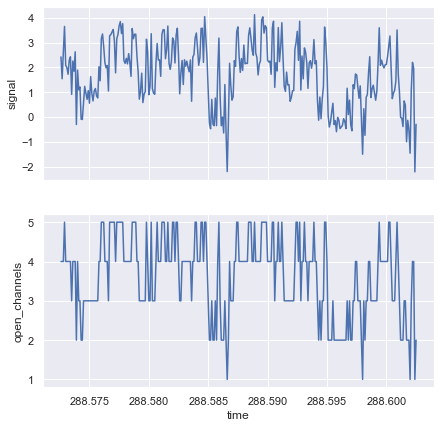

In [89]:
random.seed(1527)
rnd_start = randint(0,4500000)
interval = 300
df_sample = df_ts[rnd_start : rnd_start + interval]
_, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
sns.lineplot(x = 'time', y = 'signal', data = df_sample, ax = axes[0]);
sns.lineplot(x = 'time', y = 'open_channels', data = df_sample, ax = axes[1]);

## Feature Engineering
Since the signal is composed of discrete values of current (corresponding to discrete numbers of open ion channels) plus noise, we want to de-noise the signal before predicting the number of open channels. Here we implement an exponentially weighted moving average filter with different weights to generate additional features for each data point. 

In [6]:
df_ts_w_features = pd.DataFrame([])
for t in range(0, 5 * 10 ** 6, 5 * 10 ** 5):
    df_temp = df_ts[max(0, t - 1) : t - 1 + 5 * 10 ** 5]
    df_temp['3_avg'] = df_temp[['signal']].ewm(span=3).mean()
    df_temp['6_avg'] = df_temp[['signal']].ewm(span=6).mean()
    df_temp['12_avg'] = df_temp[['signal']].ewm(span=12).mean()
    df_temp['24_avg'] = df_temp[['signal']].ewm(span=24).mean()
    df_temp['48_avg'] = df_temp[['signal']].ewm(span=48).mean()
    df_temp['384_avg'] = df_temp[['signal']].ewm(span=384).mean()
    df_temp['1536_avg'] = df_temp[['signal']].ewm(span=1536).mean()
    df_temp['6144_avg'] = df_temp[['signal']].ewm(span=6144).mean()
    df_ts_w_features = pd.concat([df_ts_w_features, df_temp])

df_ts_w_features.head()

,time,signal,open_channels,3_avg,6_avg,12_avg,24_avg,48_avg,384_avg,1536_avg,6144_avg
0,0.0001,-2.7600,0,-2.760000,-2.760000,-2.760000,-2.760000,-2.760000,-2.760000,-2.760000,-2.760000
1,0.0002,-2.8557,0,-2.823800,-2.815825,-2.811837,-2.809844,-2.808847,-2.807975,-2.807881,-2.807858
2,0.0003,-2.4074,0,-2.585857,-2.632221,-2.653985,-2.664368,-2.669418,-2.673754,-2.674214,-2.674328
3,0.0004,-3.1404,0,-2.881613,-2.828511,-2.807528,-2.798647,-2.794622,-2.791328,-2.790988,-2.790903
4,0.0005,-3.1525,0,-3.021426,-2.942222,-2.901255,-2.881683,-2.872284,-2.864317,-2.863479,-2.863270


Here the new features correspond to exponentially weighted moving averages computed using the pandas.DataFrame.ewm function, with varing parameters for the weighting function "span". For example, the feature **3_avg** is computed using a span of 3. A larger span means that previous values are weighted more heavily.

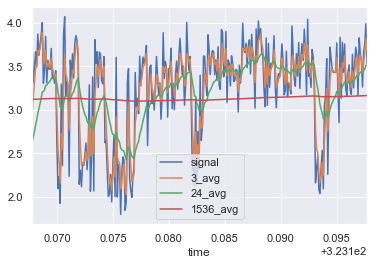

In [68]:
random.seed(0)
rnd_start = randint(0,4500000)
interval = 300
df_combined_sample = df_ts_combined[rnd_start : rnd_start + interval]
df_plot_sample = df_combined_sample[['time','signal','3_avg','24_avg','1536_avg']]
df_plot_sample.plot(x='time');

We can see that the moving averages are a smoothed version of the signal, with the largest span corresponding to a long-term average.

## Random Forest Classifier
Now that features de-noising the signal have been created, we can attempt to train a model that will then be able to classify the patch clamp current signal and determine how many ion channels are open based on the current. We will try a random forest model, and use a random search of hyperparameters to optimize.

In [7]:
# separate data in features and labels
data = df_ts_w_features[['signal','3_avg','6_avg','12_avg','24_avg','48_avg','384_avg','1536_avg','6144_avg']]
labels = df_ts_w_features[['open_channels']]

# separate into train and test set
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=0)

# train random forest classifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

# compute accuracy score
rf.score(x_test, y_test)

0.8855

The scikit-learn random forest classifier achieves an 88.5% accuracy with no hyperparameter optimization. Let's check how the predictions compare to the labels in a random consecutive sequence of the training data.

## Plot Predictions vs. Labels

In [1]:
# choose a random time to start
random.seed(23) # interesting: 23, 2211, 9211, 921, 9021, 901, 4201
interval = 100
t = random.randint(0, 5 * 10 ** 6 - interval)

# take a chunk of consecutive points in time
time = df_ts_w_features['time'][t : t + interval]
cons_sample_x = data[t : t + interval]
cons_sample_y = labels[t : t + interval].reset_index(drop=True).iloc[:,0]

predictions = rf.predict(cons_sample_x)

# combine time, labels, and predictions sample
plt_data = np.transpose(np.array([cons_sample_y, predictions])).reshape((100,2))
df_plt_data = pd.DataFrame(plt_data, np.transpose(np.array(time)), ['labels','predictions'])
df_plt_data.index.name = 'time'

# plot
ax = sns.lineplot(data= df_plt_data);
plt.ylabel('open channels');

NameError: name 'random' is not defined